## Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.stats import multivariate_normal
import sys
import moviepy.video.io.ImageSequenceClip
import os
import cv2
from keras.datasets import mnist
from sklearn.mixture import GaussianMixture
from numpy.linalg import inv
from numpy import transpose as T
from scipy.stats import multivariate_normal
from sklearn.datasets import fetch_openml
import copy

## train_set

In [2]:
# Load the MNIST dataset and normalize the features so that each value is in the range [0,1]
mnist = fetch_openml('mnist_784', version=1)
# Rescale the data
X, y = mnist.data.to_numpy() , mnist.target.to_numpy()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
# Randomly permute the data and split it into training and test sets, taking the first 500
# data samples as training and the rest as test.
permutation = np.random.permutation(X.shape[0])

X = X[permutation]
y = y[permutation]

m_training = 1000

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

# Print the labels and their frequencies in the training dataset.
print("Labels and their frequencies in the training dataset: ")
unique_labels, label_counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    print(f"{label}: {count}")

Labels and their frequencies in the training dataset: 
0: 90
1: 120
2: 108
3: 102
4: 101
5: 92
6: 93
7: 98
8: 90
9: 106


##length of train dataset

In [27]:
len(X_train)

1000

In [28]:
X_train=np.array([x.reshape((28,28)) for x in X_train ])

In [29]:
X_train.shape

(1000, 28, 28)

## plot one sample

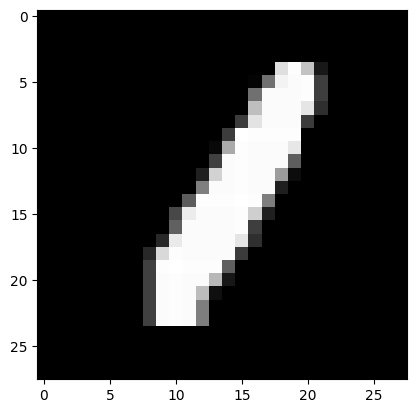

In [30]:
plt.imshow(X_train[22],cmap="gray")
plt.show()

## patchify

**This function takes an input image and divides it into overlapping patches of size m x m. It returns an array of flattened patches.**

In [31]:
def patchify(image:np.ndarray, m : int ):

    r,c=image.shape
    vec=[]
    for i in range(0,r-m+1):
        for j in range(0,c-m+1):
            vec.append(image[i:i+m,j:j+m].flatten())

    return np.array(vec)

## feature extraction

In [32]:
for i,image in enumerate(X_train):

        if(i==0):
           datapoints=patchify(image,m=16)
        else  :
           datapoints=np.concatenate((datapoints, patchify(image,m=16)), axis=0)

In [33]:
datapoints.shape

(169000, 256)

## gmm
note that, we assume that our gmm model has k=11 clusters.

In [34]:
gm = GaussianMixture(n_components=11, random_state=0).fit(datapoints)

***This function calculates the mean and covariance matrix of a patch given the current estimates of the mean (mu_k), covariance matrix (sig_k), noise variance (variance), and the mixing matrix (W). It uses Bayesian inference and returns the updated mean and covariance.***

In [79]:
def cal_mean(mu_k,sig_k,W,variance,patch):

    h,w=W.shape
    #-------------------
    sigma_y=(variance**2)*np.identity(h)
    #-------------------
    sig_MAP_inv=inv(sig_k)+W.T@inv(sigma_y)@W
    epsilon=1e-2
    sig_MAP=inv(sig_MAP_inv)+epsilon*np.eye(h)
    #-------------------
    mean_MAP=sig_MAP@(W.T@inv(sigma_y)@patch+inv(sig_k)@mu_k)

    return mean_MAP,sig_MAP

## load test image

In [85]:
def denoise(corrupted_image,m,sigma=25,num_k=11):

  patch_arr=patchify(corrupted_image,m)
  retrived_patch=[]
  for i,patch in enumerate(patch_arr) :

      mean_list,sigma_list,prob_list=[],[],[]

      for k in range(num_k):

        mean_k,sigma_k=cal_mean(gm.means_[k],gm.covariances_[k],W,sigma,patch)
        mean_list.append(mean_k)
        sigma_list.append(sigma_k)
        #--------------------
        var = multivariate_normal(mean=mean_k, cov= sigma_k ,allow_singular=True )
        prob_list.append(np.float64(gm.weights_[k]*var.pdf(mean_k)))

      j=np.argmax(prob_list)
      # sample = np.random.multivariate_normal(mean_list[j], sigma_list[j], 1)[0]           # sampling
      #-------------
      sample=np.array(copy.deepcopy(mean_list[j]),dtype="float64")
      sample[sample>255]=255
      sample[sample<1]=0
      #-------------
      retrived_patch.append(sample)

  return retrived_patch

In [86]:
def reconstruct(predicted_patches,m, length = 28 ):

    num= length - m  +1
    count_matrix = np.zeros((28, 28))
    reconstructed_matrix= np.zeros((28, 28))
    #---------------------------------
    for i,patch in enumerate(predicted_patches):

        patch_temp= patch.reshape((m, m))
        count_temp= np.ones((m,m))
        #-------------------
        col = i // num
        row =  i % num
        #-------------------
        reconstructed_matrix[col:col+m,row:row+m]+=patch_temp
        count_matrix[col:col+m,row:row+m]+=count_temp


    reconstructed_matrix = np.array(reconstructed_matrix / count_matrix,dtype='float64')

    return reconstructed_matrix

## reconstruct noisy image
below, you can see 5 different original samples, along with noisy and denoised version of them.

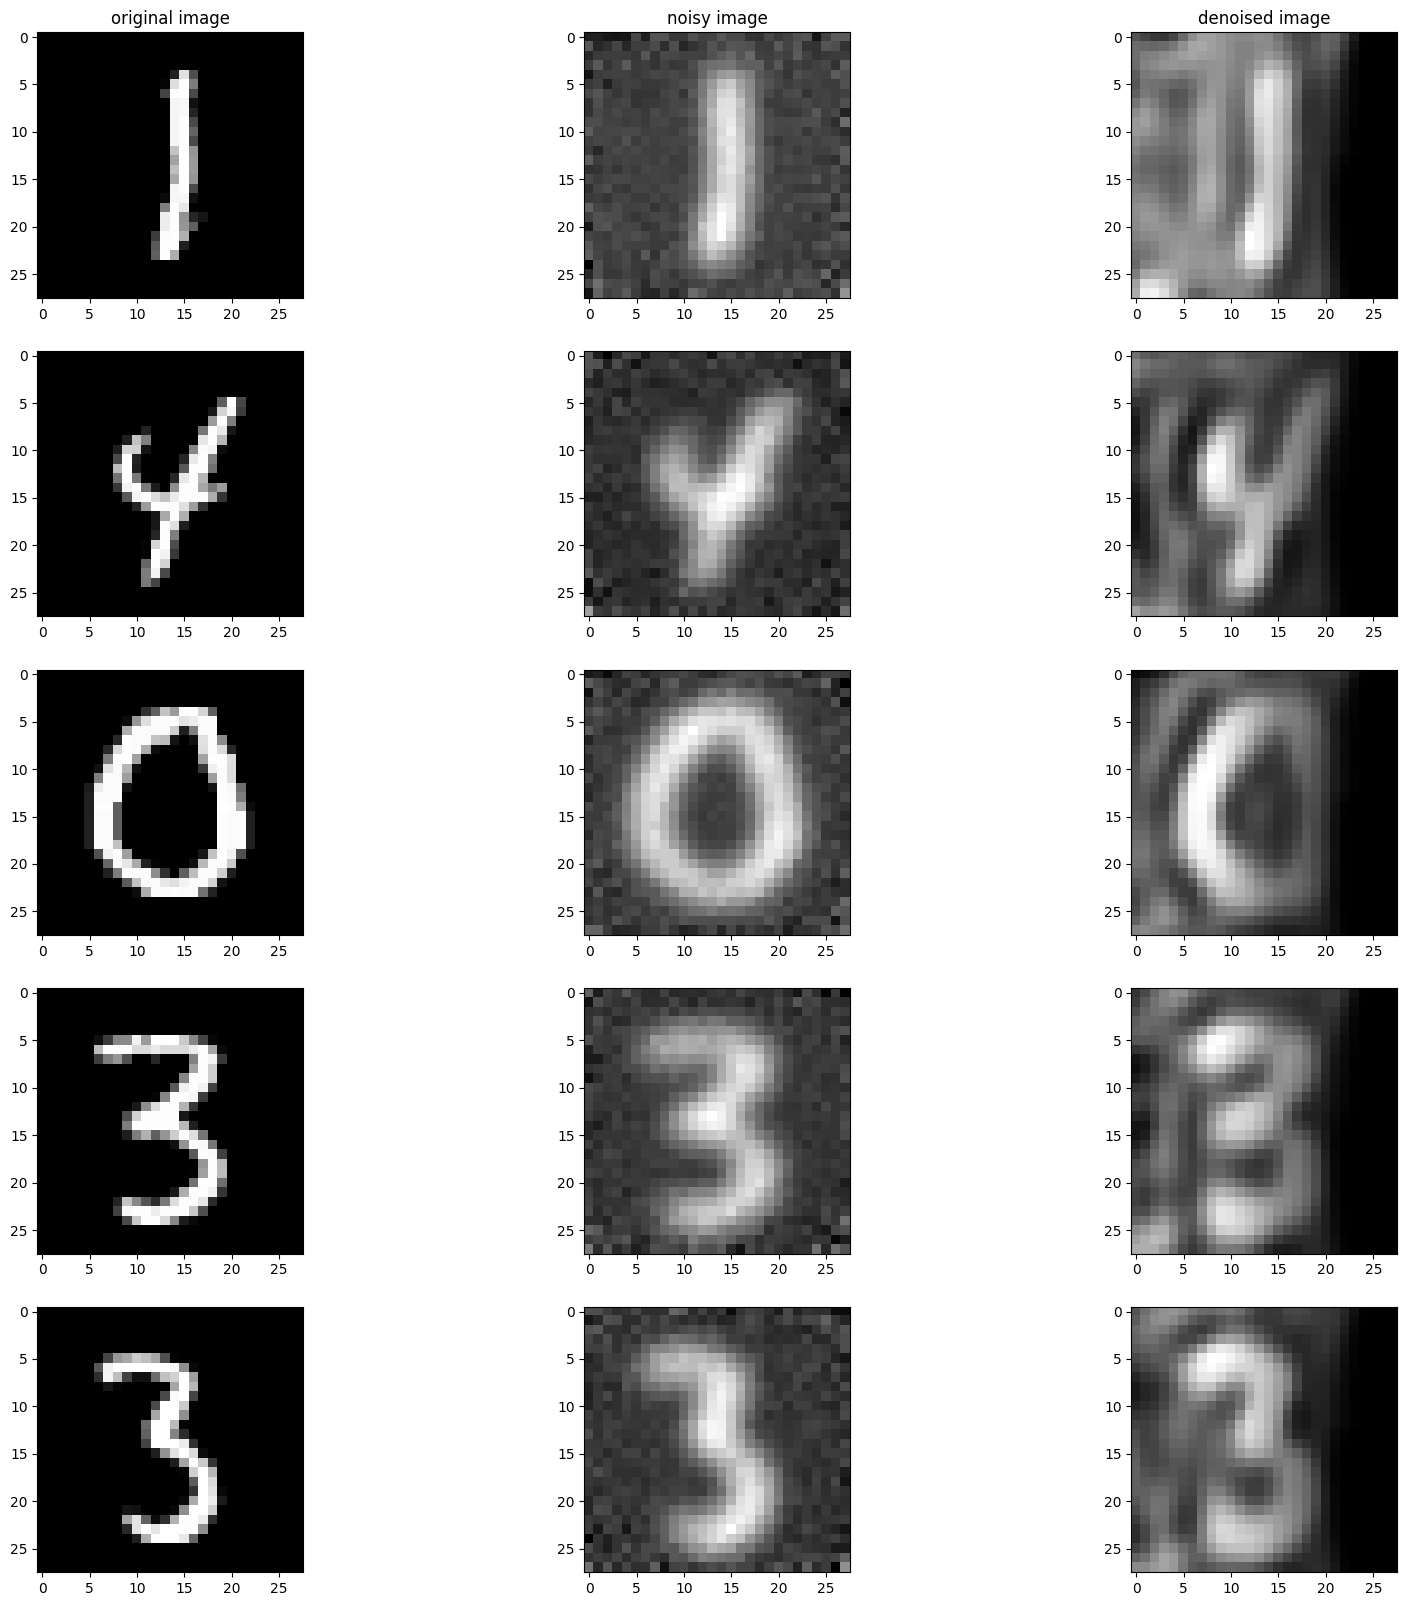

In [89]:
plt.figure(figsize=(20, 20))

for number in range(0,5):

    plt.subplot(5,3,(number)*3+1)
    original_image=plt.imread(f"/content/MNIST/original/10{number}.png")
    original_image=np.array(255*original_image,dtype="uint8")

    plt.imshow(original_image,cmap='gray')
    if(number==0):
      plt.title("original image")

    noisy_image=plt.imread(f"/content/MNIST/corrupted/10{number}.png")
    noisy_image=np.array(255*noisy_image,dtype="uint8")
    plt.subplot(5,3,(number)*3+2)
    plt.imshow(noisy_image,cmap='gray')
    if(number==0):
      plt.title("noisy image")

    retrived_patch=denoise(noisy_image,16)
    retrived_image = reconstruct(retrived_patch,16)
    plt.subplot(5,3,(number)*3+3)
    plt.imshow(np.array(retrived_image,dtype='uint8'),cmap='gray')

    if(number==0):
       plt.title("denoised image")

## **Best Hyperarameters**
$1) \ standard  \ deviation = \sigma=20$

$2) \ size \ of  \ gaussian \ clusters=11$

$3) \ m=16$

$4 ) \ epsilon \ for \ handle \ singularity= 0.01$